In [54]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt

In [55]:
def makeUserTarget(df, user):
    aux = []
    for _, row in df.iterrows():
        if row.our_data == 0:
            if(np.floor(row.SessionID/100).astype(int) == user):
                aux.append(1)
            else:
                aux.append(0)
        else:
            if 'Diego' in row.SessionID and user == 'Diego':
                aux.append(1)
            elif 'Toto' in row.SessionID and user == 'Toto':
                aux.append(1)
            elif (('Jo' in row.SessionID) or ('jo' in row.SessionID)) and user == 'Jo':
                aux.append(1)
            else:
                aux.append(0)
    df['target'] = aux

In [56]:
def separateIntoTrainAndTest(df, test_sessions = []):
    targetSessionIds = list(df[df.target == 1].SessionID.unique())
    targetChoosenSession = random.choice(targetSessionIds)
    notTargetSessionIds = list(df[df.target == 0].SessionID.unique())
    notTargetChoosenSessions = test_sessions
    for i in range(2):
        notTargetChoosenSession = random.choice(notTargetSessionIds) 
        notTargetChoosenSessions.append(notTargetChoosenSession)
        notTargetSessionIds.remove(notTargetChoosenSession)
    df_train = df[(df.SessionID != targetChoosenSession) & (~df.SessionID.isin(notTargetChoosenSessions))]
    df_test = df[(df.SessionID == targetChoosenSession) | (df.SessionID.isin(notTargetChoosenSessions))]
    
    return df_train, df_test

In [57]:
def getOurDataUsers(row):
    if 'Diego' in row.SessionID :
        return('Diego')
    elif 'Toto' in row.SessionID:
        return('Toto')
    elif ('Jo' in row.SessionID) or ('jo' in row.SessionID):
        return('Jo')

In [58]:
file_name = 'aggregated_features'
our_data_file_name = 'our_data_aggregated_features'
to_drop = []
df = pd.read_csv('./' + file_name + '.csv')
our_data_df = pd.read_csv('./' + our_data_file_name + '.csv')
df['our_data'] = 0
our_data_df['our_data'] = 1

In [59]:
users = (np.floor(df.SessionID/100).astype(int)).unique()
our_data_users = our_data_df.apply(getOurDataUsers,axis=1)

In [60]:
df = df.append(our_data_df,ignore_index=True)

In [61]:
#df = df[df.our_data != 0]

In [62]:
sessionsToDrop = ['Diego01','Diego02','Diego03']

In [63]:
df = df[~df.SessionID.isin(sessionsToDrop)]

In [66]:
#user = random.choice(users)
user = 'Toto'
makeUserTarget(df, user)

In [67]:
#to_drop =  ['our_data','Contact_size_mean','Contact_size_std'] 
to_drop =  ['our_data','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std']

In [68]:
clf = xgb.XGBClassifier(n_estimators=90, max_depth=9, random_state=31, colsample_bytree=0.6, colsample_bylevel=0.5, learning_rate=0.11, subsample=0.9)
#clf = RandomForestClassifier()

In [69]:
df = df.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)

In [70]:
x_train, y_train = df.drop("target", axis=1), df["target"]

In [71]:
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.6, gamma=0, learning_rate=0.11, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

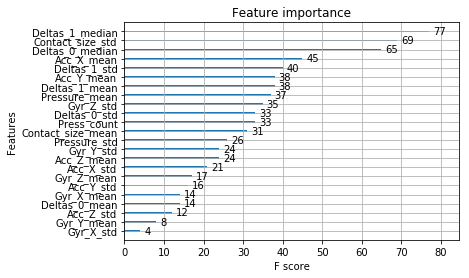

In [72]:
xgb.plot_importance(clf)
plt.figure()